##Imports

In [33]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

##Function Definitions

In [34]:
def perpendicular_vector(v):
    return [v[0], v[1]]

    # return [-v[1], v[0]]

def point_on_object(point, objects, threshold=10):
    """
    Check if the point is on any of the objects by measuring the distance to each object's points.
    If the distance is less than the threshold, we consider the point to be on the object.

    :param point: The point to check.
    :param objects: The list of objects (clusters of points).
    :param threshold: The distance threshold to consider a point is on the object.
    :return: The index of the object that the point is on, or None if it's on no object.
    """
    for i, obj in enumerate(objects):
        distances = np.linalg.norm(obj - point, axis=1)
        if np.any(distances < threshold):
            return i
    return None


# def find_closest_aligned_point(start, direction, objects):
#     aligned_points = []
#     for obj in objects:
#         # Exclude the object that the position lies on
#         if any(np.array_equal(point, start) for point in obj):
#             continue
#         for point in obj:
#             # Calculate the y value on the line for the current x value
#             y_on_line = (direction[1] / direction[0]) * (point[0] - start[0]) + start[1]
#             if np.isclose(point[1], y_on_line, atol=2):  # Adjust the tolerance as needed
#                 aligned_points.append(point)

#     # If there are no aligned points, return None
#     if not aligned_points:
#         return None

#     # Convert the list of points to an array
#     aligned_points = np.array(aligned_points)

#     # Find the closest point to the start position
#     distances = np.linalg.norm(aligned_points - start, axis=1)
#     closest_point = aligned_points[np.argmin(distances)]

#     return closest_point


def find_closest_aligned_point(start, direction, objects):
    aligned_points = []
    for obj in objects:
        # Exclude the object that the position lies on
        if any(np.array_equal(point, start) for point in obj):
            continue
        for point in obj:
            # Calculate the y value on the line for the current x value
            y_on_line = (direction[1] / direction[0]) * (point[0] - start[0]) + start[1]
            if np.isclose(point[1], y_on_line, atol=2):  # Adjust the tolerance as needed
                # Create a vector from the start point to the current point
                point_vector = point - start
                # Calculate the dot product between the direction vector and point_vector
                dot_product = np.dot(direction, point_vector)
                # Check if the point is in the direction of the vector
                if dot_product > 0:
                    aligned_points.append(point)

    # If there are no aligned points, return None
    if not aligned_points:
        return None

    # Convert the list of points to an array
    aligned_points = np.array(aligned_points)

    # Find the closest point to the start position in the direction of the vector
    distances = np.linalg.norm(aligned_points - start, axis=1)
    closest_point_index = np.argmin(distances)
    closest_point = aligned_points[closest_point_index]

    return closest_point


def find_normal(points, incoming_vector):
    # Compute the centroid of the points
    centroid = np.mean(points, axis=0)

    # Compute the points relative to the centroid
    relative_points = points - centroid

    # Compute the covariance matrix of the relative points
    cov = np.cov(relative_points, rowvar=False)

    # Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # The normal vector is the eigenvector corresponding to the smallest eigenvalue
    normal = eigenvectors[np.argmin(eigenvalues)]
    normal = np.array([-normal[0], normal[1]])  # Swap the components to get (x, y) order

    # Ensure the normal vector points towards the incoming vector
    if np.dot(normal, incoming_vector) > 0:
        normal = -normal  # Reverse the direction of the normal vector

    return normal



##Main Running Code

test1 none image: True
test2 labels : [0 0 0 ... 3 3 3]
ITERATION : 0
init vector:[0.19611614 0.98058068]
start_object_index: 3
NORMAL: [-0.0015913  -0.99999873]
refelcted_vector : [ 0.19299436 -0.98119987]


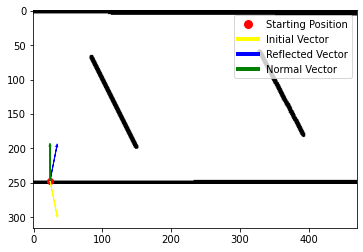

ITERATION : 1
init vector:[ 0.19299436 -0.98119987]
start_object_index: 0
NORMAL: [-0.00331324  0.99999451]
refelcted_vector : [0.18648825 0.98245719]


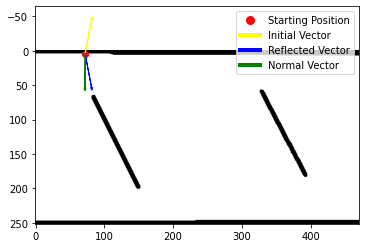

ITERATION : 2
init vector:[0.18648825 0.98245719]
start_object_index: 2
NORMAL: [ 0.89444259 -0.4471828 ]
refelcted_vector : [0.67402194 0.73871133]


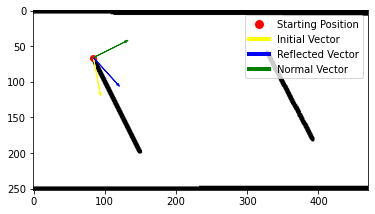

ITERATION : 3
init vector:[0.67402194 0.73871133]
start_object_index: 3
NORMAL: [-0.0015913  -0.99999873]
refelcted_vector : [ 0.67166751 -0.74085272]


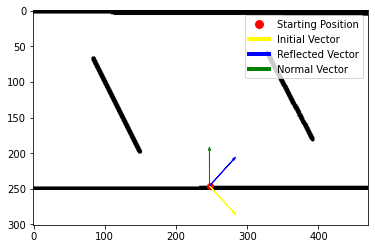

ITERATION : 4
init vector:[ 0.67166751 -0.74085272]
start_object_index: 1
NORMAL: [-0.88530469  0.46501141]
refelcted_vector : [-0.99117437  0.13256459]


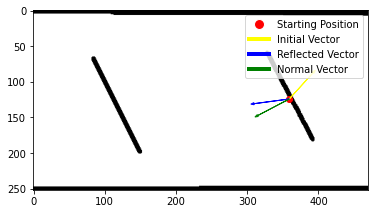

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize
from matplotlib.lines import Line2D

# Load the image and convert to grayscale for obstacle detection
image = cv2.imread('arena.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.blur(gray, (5, 5))

binary_image = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)[1]  # Threshold value of 127

print(f"test1 none image: {binary_image.shape !=None}")

# Find the black objects using DBSCAN
y_indices, x_indices = np.nonzero(binary_image == 0)
coordinates = np.column_stack([x_indices, y_indices])
db = DBSCAN(eps=2, min_samples=5).fit(coordinates)
labels = db.labels_

print(f"test2 labels : {labels}")

objects = []
for i in np.unique(labels):
    if i != -1:  # Ignore noise
        objects.append(coordinates[labels == i])

# Define the initial position and vector
x = 0
y = int(binary_image.shape[0] / 2)
dx = 50
dy = 250

# y = int(binary_image.shape[0] / 3)
# dx = 10
# dy = 25
start_position = np.array([x, y], dtype=float)
vector = np.array([dx, dy], dtype=float)

# Normalize the vector
vector = normalize(vector.reshape(1, -1))[0]

# Compute the normal vectors for each object
# normals = [find_normal(obj) for obj in objects] //todo
normals = []


# Find the index of the object that contains the start position
start_object_index = next(i for i, obj in enumerate(objects) if start_position in obj)

# Define the center and radius of the circular area
center = np.array([binary_image.shape[1] // 2, binary_image.shape[0] // 2])
radius = 10

# Initialize the total length
total_length = 0

positions= []
for _ in range(5):
    print(f"ITERATION : {_}")
    closest_aligned_point = find_closest_aligned_point(start_position, vector, objects)
    print(f"init vector:{vector}")


    if closest_aligned_point is None:
        # If there are no aligned points, break the loop
        print("No Aligned Points ! ")
        break

    # Calculate the distance to the closest aligned point
    distance = np.linalg.norm(closest_aligned_point - start_position)
    total_length += distance

    # WINNER CONDITION
    if np.linalg.norm(start_position - center) <= radius:
        # If it is, break the loop and return the initial starting position, the angle of the vector, and the total length
        angle = np.arctan2(vector[1], vector[0])
        print("##################################### WINNER CONDITION #####################################")
        print(f"Initial starting position: {start_position}, Angle of the vector: {angle}, Length: {total_length}")
        break

    # Move to the closest aligned point
    start_position = closest_aligned_point
    positions.append(start_position)


    start_object_index = point_on_object(start_position, objects)

    print(f"start_object_index: {start_object_index}")

    # Assuming normals[start_object_index] is already a normalized normal vector
    normal = find_normal(objects[start_object_index], vector)


    print(f"NORMAL: {normal}")

    normals.append(normal)

    # Calculate the dot product of the vector and the normal
    dot_prod = np.dot(vector, normal)

    # Calculate the reflected vector
    reflected_vector = vector - 2 * dot_prod * normal


    print(f"refelcted_vector : {reflected_vector}")

    # Create custom legend entries
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Starting Position', markerfacecolor='red', markersize=10),
        Line2D([0], [0], color='yellow', lw=4, label='Initial Vector'),
        Line2D([0], [0], color='blue', lw=4, label='Reflected Vector'),
        Line2D([0], [0], color='green', lw=4, label='Normal Vector')
    ]

    # Add the legend to the plot with custom entries
    plt.legend(handles=legend_elements, loc='upper right')

    # Draw the point and vector on the image
    plt.imshow(binary_image, cmap='gray')
    plt.scatter(start_position[0], start_position[1], color='red')
    plt.arrow(start_position[0], start_position[1], vector[0]*50, vector[1]*50, color='yellow', head_width=3)
    plt.arrow(start_position[0], start_position[1], reflected_vector[0]*50, reflected_vector[1]*50, color='blue', head_width=3)
    # Draw the normal vector of the object that the start position is on
    plt.arrow(start_position[0], start_position[1], normals[_][0]*50, normals[_][1]*50, color='green', head_width=3)
    plt.pause(0.001)  # Pause to update the figure



    # Update the vector to the reflected vector for the next iteration
    vector = reflected_vector

# Keep the plot open
plt.show()


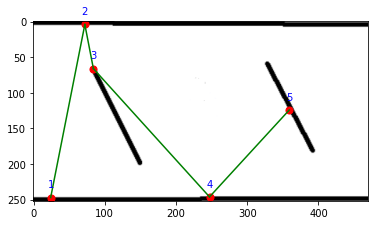

In [41]:
image_rgb = cv2.imread('arena.png')

# Convert the image to RGB (matplotlib expects RGB format)

# Create a figure and axis to plot on
fig, ax = plt.subplots()

# Display the image
ax.imshow(image_rgb)

# Loop through the positions and plot each one
for i, position in enumerate(positions):
    # Scatter plot for the point
    ax.scatter(position[0], position[1], color='red', s=50)  # s is the size of the point

    # Annotate the point with its number
    ax.annotate(str(i + 1), (position[0], position[1]), textcoords="offset points", xytext=(0,10), ha='center', color='blue')

    # If not the first point, draw a line from the previous point
    if i > 0:
        # Get the previous point
        prev_position = positions[i - 1]
        # Draw a line from the previous point to the current point
        ax.plot([prev_position[0], position[0]], [prev_position[1], position[1]], color='green')

# Show the plot
plt.show()

##Itreration 360x800x5

##Object detection

In [37]:
# # Importing required libraries
# from skimage.segmentation import slic
# from skimage.data import astronaut
# from skimage.color import label2rgb

# # Setting the plot size as 15, 15
# plt.figure(figsize=(15,15))

# # Sample Image of scikit-image package
# astronaut = cv2.imread('/content/area.jpeg')

# # Applying Simple Linear Iterative
# # Clustering on the image
# # - 50 segments & compactness = 10
# astronaut_segments = slic(astronaut,
#                           n_segments=5,
#                           compactness=5)
# plt.subplot(1,2,1)

# # Plotting the original image
# plt.imshow(astronaut)
# plt.subplot(1,2,2)

# # Converts a label image into
# # an RGB color image for visualizing
# # the labeled regions.
# plt.imshow(label2rgb(astronaut_segments,
#                      astronaut,
#                      kind = 'avg'))